This project aims to predict whetever bank client will make a prepayment of mortage, is uses Logisitic Regression to make such classification.

In [ ]:
import pandas as pd 
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np  
import seaborn as sns   
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv(r"c:\Users\kubus\Downloads\stopy.csv")
df

,klient_id,miesiac,LTV,wiek,saldo_kredytu,stopa_nbp,przedplata,regularna_nadplata,kontakt_z_bankiem,wielo_produktywny,historia_nadplat,logowania_online
0,1,2023-03-01,44.3,32,464550,6.75,0,1,0,0,0,5
1,2,2022-05-01,51.8,45,576040,5.25,0,0,1,0,0,4
2,3,2021-03-01,76.6,35,266866,0.10,1,1,0,0,0,8
3,4,2023-07-01,67.4,62,421516,6.75,0,0,1,1,0,8
4,5,2020-08-01,46.4,32,663765,0.10,0,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,2021-09-01,79.5,48,692879,0.10,0,0,1,0,0,4
2996,2997,2020-04-01,46.0,27,481965,0.50,0,0,0,1,1,6
2997,2998,2022-09-01,47.0,54,364826,6.75,1,0,1,1,0,5
2998,2999,2022-03-01,54.3,37,211186,3.50,1,0,0,1,1,0


Exploratory data analysis

<Axes: >

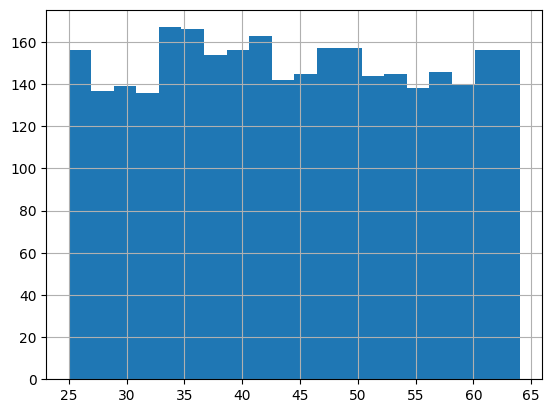

In [37]:
df["wiek"].hist(bins=20)

<Axes: >

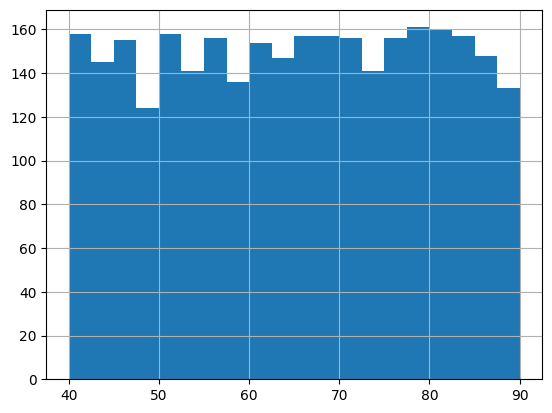

In [38]:
df["LTV"].hist(bins=20)


<Axes: >

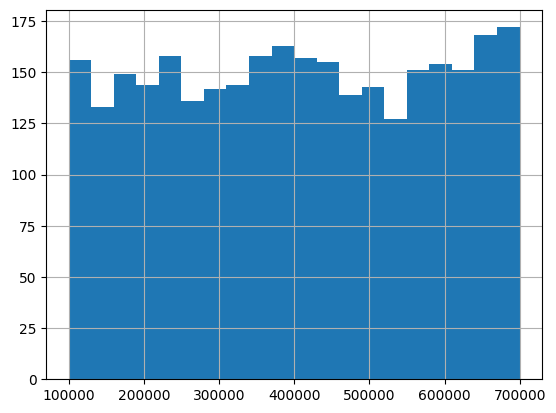

In [40]:
df["saldo_kredytu"].hist(bins=20)

<Axes: >

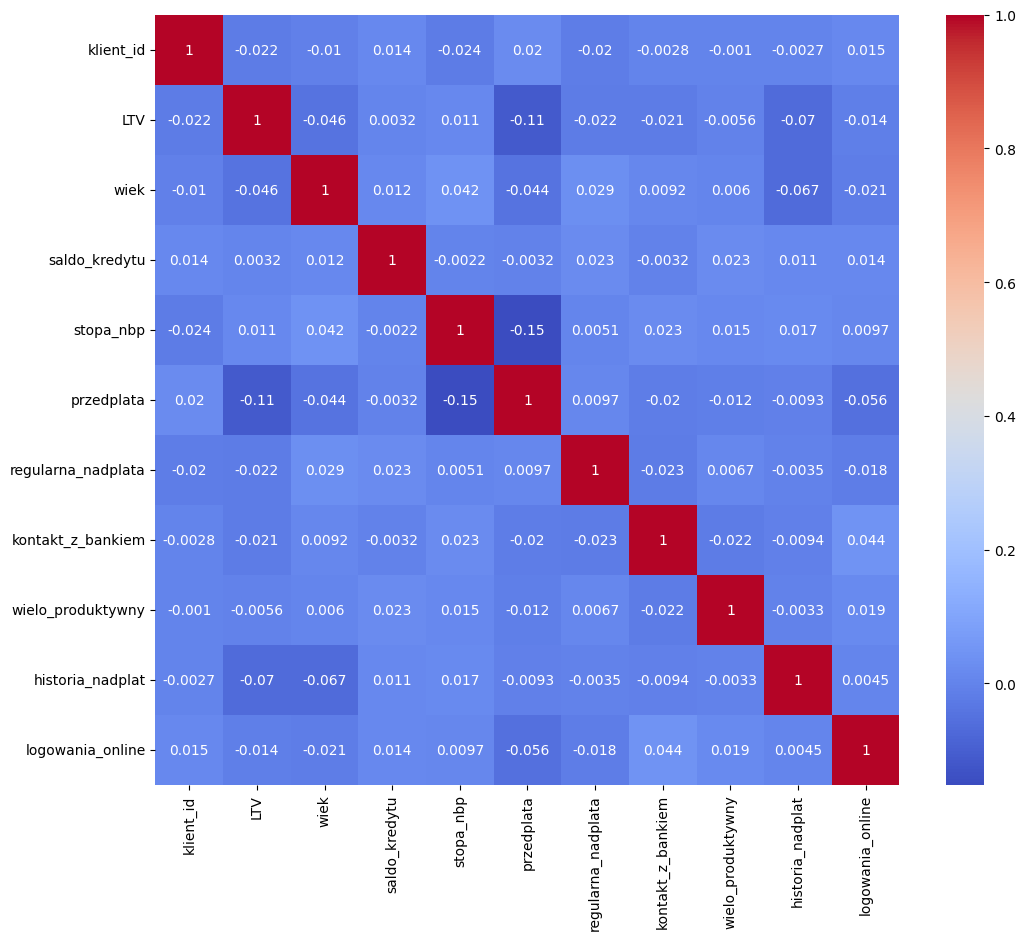

In [5]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12,10))
sns.heatmap(
    correlation_matrix,
    cmap = "coolwarm",
    annot=True
)

Heatmap shows that correlations are rather small biggest are between interest rate (stopa_nbp) and prepayment (przedpłata), both -0.15

In [ ]:
df["wiek_sqr"] = df["wiek"] ** 2

X = df[['stopa_nbp', 'LTV', 'wiek', "wiek_sqr", 'saldo_kredytu','regularna_nadplata', 'kontakt_z_bankiem', 'wielo_produktywny', 'historia_nadplat', 'logowania_online']]
y = df["przedplata"]


Splitting data using StratifiedShuffleSplit

In [83]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Scaling variables

In [85]:
scaler = StandardScaler()

X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[['stopa_nbp', 'LTV', 'wiek', 'saldo_kredytu', "wiek_sqr",  "logowania_online"]] = scaler.fit_transform(X_train[['stopa_nbp', 'LTV', 'wiek', 'saldo_kredytu', "wiek_sqr",  "logowania_online"]])
X_test_s[['stopa_nbp', 'LTV', 'wiek', 'saldo_kredytu', "wiek_sqr",  "logowania_online"]] = scaler.transform(X_test[['stopa_nbp', 'LTV', 'wiek', 'saldo_kredytu', "wiek_sqr",  "logowania_online"]])

In [86]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train_s.values, i) for i in range(X_train_s.shape[1])]
print(vif)



         VIF
0   1.005010
1   1.011619
2  74.464515
3  74.436866
4   1.001730
5   1.150918
6   1.287949
7   1.367611
8   1.141389
9   1.003948


Checking how distributed is y variable

In [87]:
print(y.value_counts())

przedplata
0    2166
1     834
Name: count, dtype: int64


Fitting LogisticRegression with balanced weight classes to ensure equal distrubtion of y variable

In [89]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_s, y_train) 

y_pred = model.predict(X_test_s)
y_proba = model.predict_proba(X_test_s)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       433
           1       0.36      0.62      0.45       167

    accuracy                           0.58       600
   macro avg       0.58      0.59      0.56       600
weighted avg       0.67      0.58      0.60       600



Checking AUC and impact of each variable on prepayment

AUC: 0.6272904537345632


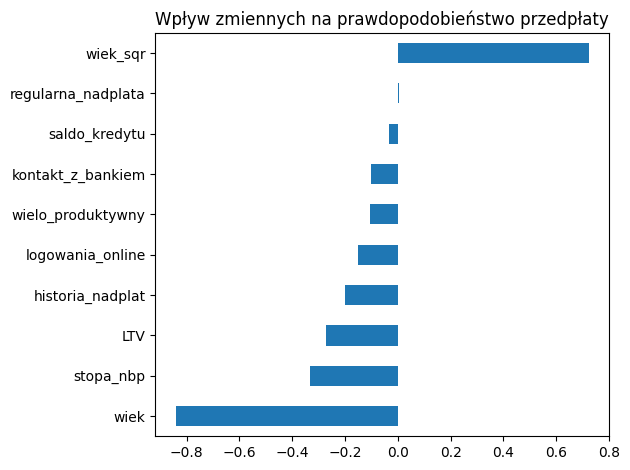

In [ ]:

print("AUC:", roc_auc_score(y_test, y_proba))


coeffs = pd.Series(model.coef_[0], index=X.columns).sort_values()
coeffs.plot(kind='barh', title='Wpływ zmiennych na prawdopodobieństwo przedpłaty')
plt.tight_layout()
plt.show()

We observe that age (wiek) and age_sqr (wiek_sqr) have the greatest impact on probability of prepayment. Greatest probability is for young people and older people, clients in the midddle age have the lowest probability. Suprisngly regular prepayment (regularna nadpłata) as well as credit value (saldo_kredytu) have very low impact.

Confussion matrix

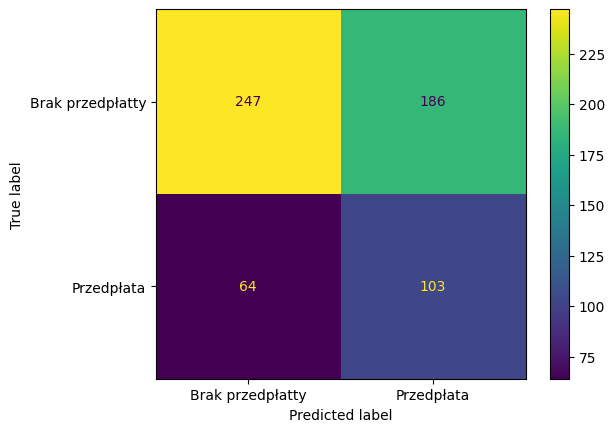

In [93]:
cm = confusion_matrix(y_test, y_pred)
wyniki = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Brak przedpłatty", "Przedpłata"])
wyniki.plot()

Showing top 10 client with highest probability of prepayment

In [95]:
y_proba

df_top10 = X_test.copy()

df_top10["prawdopodobieństwo_przedpłaty"] = y_proba
df_top10["przedpłata"] = y_test.values
df_top10["predykcja"] = y_pred


df_top10 = df_top10.sort_values(by="prawdopodobieństwo_przedpłaty", ascending=False)

df_top10.head(10)

,stopa_nbp,LTV,wiek,wiek_sqr,saldo_kredytu,regularna_nadplata,kontakt_z_bankiem,wielo_produktywny,historia_nadplat,logowania_online,prawdopodobieństwo_przedpłaty,przedpłata,predykcja
1356,0.10,43.2,26,676,172746,0,0,1,0,3,0.778590,1,1
960,0.10,46.2,28,784,326301,0,0,0,0,4,0.757638,0,1
1365,1.25,50.9,25,625,396437,0,1,0,0,1,0.753393,1,1
2059,1.50,40.1,34,1156,318811,0,1,0,0,0,0.748049,0,1
878,0.10,65.8,26,676,164829,0,0,0,0,1,0.746097,0,1
2149,0.10,51.3,25,625,487476,0,0,1,0,4,0.733733,1,1
2061,0.10,47.2,62,3844,617447,0,0,0,0,0,0.730301,0,1
2590,0.10,47.2,29,841,261554,0,0,1,0,4,0.729817,0,1
2912,0.50,44.4,28,784,203976,0,0,1,0,5,0.726533,0,1
1169,0.50,52.7,26,676,431301,0,1,1,0,2,0.721054,1,1
